In [106]:
cd ../content/drive/MyDrive/DMfinal/scripts

[Errno 2] No such file or directory: '../content/drive/MyDrive/DMfinal/scripts'
/content/drive/MyDrive/DMfinal/scripts


In [107]:
# INSTALLATIONS TO DELETE *****
!pip install pandas
!pip install numpy
!pip install scipy
!pip install six
!pip install scikit-learn
!pip install rds2py
!pip install yellowbrick
!pip install imblearn
!pip install statsmodels
!pip install joblib
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 4.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of genomicranges to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163764 sha256=483632104921fbd05ebf30f56ba14e657b4515a82c25049aac0595726621d4bc
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [108]:
'''import os
import numpy as np
import scipy
import sklearn
import pandas as pd
import requests
import rds2py
import scipy.sparse
import logging
from io import BytesIO
import gzip
from scipy.sparse import csr_matrix
import six, yellowbrick, imblearn, statsmodels, joblib
import matplotlib.pyplot as plt
import seaborn as sns
import random'''

# MYUTILS

In [109]:
# MYUTILS **********************************************************************
'''import os
import pandas as pd
import requests
import rds2py
import scipy.sparse
import logging
from io import BytesIO
import gzip'''

logging.basicConfig(filename='example.log', encoding='utf-8', level=logging.DEBUG)

# Create directory function
def create_directory(directory_name):
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)
        print("Directory successfully created:", directory_name)
        return True  # Return True to indicate the directory was created
    else:
        print("Directory already exists:", directory_name)
        return False  # Return False if the directory already exists

def get_csv(fname):
    df = pd.read_csv(fname)
    return df

def save_to_csv(file, output_dir, name, announce = True):

    full_path = os.path.join(output_dir, name)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    file.write_csv(full_path, separator=",")
    if announce:
            print(f'{"<" * 10} Processed data saved to {os.path.join(output_dir, name)} {">" * 10}')

def read_url_func(url):

    response = requests.get(url)

    # Send an HTTP HEAD request to the URL to check the headers
    response_head = requests.head(url)

    # Check the 'Content-Encoding' header
    content_encoding = response_head.headers.get('Content-Encoding', '')
    file_extension = os.path.splitext(url)[1]

    if response.status_code == 200:
        if 'gzip' in content_encoding or file_extension == '.gz':
            # Fetch the compressed CSV data
            response_content = BytesIO(response.content)

            # Decompress the content and read into a pandas DataFrame
            with gzip.GzipFile(fileobj=response_content) as decompressed:
                df = pl.read_csv(decompressed.read(), separator = ',', ignore_errors=True )
            return df
        else:
            print(f"File extension: {file_extension}")
            print(f"Content encoding: {content_encoding}")
            # Parse the data from the response into a DataFrame
            # df = pl.read_csv(url)  # You can adjust this line depending on the data format
            # return df
    else:
        print('Failed to request data')


# Automated File Reading Based on User-Initialized Variables. Returns dataframe
def get_data(input_dir, url=None, file_name=None, file_path=None, read_type='url'):
    if read_type == 'url':
        df = read_url_func(url)
        print(f'{"<" * 10} URL File Read Successfully {">" * 10}')
        save_to_csv(df, input_dir, file_name)
        df.head
        return df
    elif read_type == 'disk':
        full_path = os.path.join(input_dir, file_path) # create path to download existing file
        file_extension = os.path.splitext(file_path)[1] # get the file type
        if file_extension == '.csv':
            df = pd.read_csv(full_path)
            print(f'{"<" * 10} CSV File Read Successfully {">" * 10}')
            return df
        if file_extension == '.rds': # note the save_to_csv statements are commented out bc runtime is too long
            matrix, dim_1 = read_rds(full_path)
            print(f'{"<" * 10} RDS File Read Successfully {">" * 10}')
            df = pl.DataFrame(matrix, schema=dim_1)
            #save_to_csv(df, input_dir, file_name)
            #print('SUCCESSFULLY SAVED DATAFRAME TO CSV!')
            return df

def read_rds(file_path):
    rObj = rds2py.read_rds(file_path)
    data_dims = rObj["attributes"]["Dim"]["data"]
    #dim_0 = rObj["attributes"]["Dimnames"]["data"][0]["data"]
    dim_1 = rObj["attributes"]["Dimnames"]["data"][1]["data"]

    i_dgCMatrix = rObj["attributes"]["i"]["data"]
    p_dgCMatrix = rObj["attributes"]["p"]["data"]
    none_zero_values_dgCMatrix = rObj["attributes"]["x"]["data"]

    sparse_matrix = scipy.sparse.csc_matrix((none_zero_values_dgCMatrix, i_dgCMatrix, p_dgCMatrix), shape=data_dims)
    dense_matrix = sparse_matrix.toarray()
    return dense_matrix, dim_1

# Filter out users and items with less ratings associated by determined threshold
def filter_data(df, col_name, min_val=0):
    # Filter out users who have only rated items 1 to 3 times
    total_counts = df[col_name].value_counts()
    filtered_col = total_counts[total_counts > min_val].index
    filtered_df = df[df[col_name].isin(filtered_col)]
    print(filtered_df.shape)

    '''total_counts = df[col_name].value_counts()
    filtered_col = total_counts[total_counts > min_val].index
    filtered_df = df[df[col_name].isin(filtered_col)]    '''
    print('Filtered dataframe shape: ',filtered_df.shape)
    return filtered_df

#CLEANDATA

In [110]:
# CLEAN DATA MODULE **********************************************************************
'''import os
import numpy as np
import pandas as pd'''

def clean_data(df, y_train, time_stamp_present, time_stamp_col, target):

    dfcopy = df
    dfcopy[target] = y_train
    if time_stamp_present == True:
        dfcopy = dfcopy.drop([time_stamp_col],axis=1)

    df_dropped = drop_duplicates(df=dfcopy)
    df_no_null = drop_null(df=df_dropped)
    df_cleaned = drop_out_of_domain(df=df_no_null)

    return df_cleaned

def drop_duplicates(df):
    # Drop duplicate rows
    print('\nDuplicate row removal:')
    print('Sample count before: ', len(df.index))
    df_no_duplicates = df.drop_duplicates()
    print('Sample count after: ', len(df_no_duplicates.index))

    return df_no_duplicates

def drop_null(df):
     # Drop rows with null values
    df_no_nulls = df.dropna()

    print('\nNull row removal:')
    print('Sample count before: ', len(df.index))
    print('Sample count after: ', len(df_no_nulls.index))

    return df_no_nulls

def drop_out_of_domain(df, std = 2):
    # Get only numeric data to identify rows with out-of-domain properties
    df_numeric = numeric_only(df)

    # Calculate the mean and standard deviation of all row means
    print('\nOut-of-domain row removal:')
    all_rows_mean = df_numeric.mean(axis=1)
    all_rows_mean_mean = all_rows_mean.mean()
    all_rows_mean_std = all_rows_mean.std()
    threshold_std = std
    threshold = all_rows_mean_mean + threshold_std * all_rows_mean_std
    print('Threshold =', threshold_std, ' standard deviations')

    out_of_domain_indices = []

    # Iterate over rows and check for out-of-domain properties
    for idx, row in df_numeric.iterrows():
        row_mean = row.mean()
        if row_mean > threshold:
            out_of_domain_indices.append(idx)
            #print(f"Row {idx} has out-of-domain properties.")

    df_reduced = df.drop(out_of_domain_indices)
    print('Number of rows with out-of-domain properties: ',len(out_of_domain_indices))
    print('Sample count before: ', len(df.index))
    print('Sample count after: ', len(df_reduced.index))

    return df_reduced

def numeric_only(df):
    # Select numeric columns
    numeric_columns = df.select_dtypes(include='number')

    # Create a copy with only numeric columns
    df_numeric = numeric_columns.copy()

    return df_numeric


#PREP DATA

In [131]:
from surprise.model_selection import GridSearchCV, cross_validate
from surprise import accuracy
from surprise import KNNBaseline, KNNBasic
from surprise.model_selection import KFold

def cross_val(data, model_class, param_grid, model_grid_pairs, kf):
  # Perform cross-validation and grid search for each model
  best_params_list = []
  for model_class, param_grid in model_grid_pairs:
      print(f"\n{'='*40}\n{model_class.__name__}\n{'='*40}")

      # Initialize the GridSearchCV object
      grid_search = GridSearchCV(model_class, param_grid, measures=['rmse', 'mae'], cv=kf, n_jobs=-1)

      # Perform the grid search on the full dataset
      grid_search.fit(data)

      # Print best RMSE and MAE scores and corresponding parameters
      print(f"Best RMSE Score: {grid_search.best_score['rmse']:.4f}")
      print(f"Best MAE Score: {grid_search.best_score['mae']:.4f}")
      print(f"Best Parameters: {grid_search.best_params}\n")

      best_params_list.append(grid_search.best_params)

  return best_params_list

#VISUALIZE_DATA

In [112]:
# VISUALIZATION MODULE **********************************************************
'''import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import numpy as np
import os'''

# Wrapper function that calls all the data visualization functions
def print_visuals(df, user_id, item_id, target_attribute, random_state, num_users, num_items):
    ratings_distribution(df, user_id, item_id)
    correlation_heatmap(df, user_id, item_id, target_attribute, random_state, num_users, num_items)

# Function that calls the two functions relating to the distribution of ratings
def ratings_distribution(df, user_id, item_id):
    # visualize ratings per user
    ratings_per_user(df, user_id)

    # visualize ratings per item
    ratings_per_item(df, item_id)

# Function to display the number of ratings per user
def ratings_per_user(df, user_id):
    # Get the number of unique users
    unique_ids = df[user_id].nunique()
    print("Number of unique users: ", unique_ids)

    # Group users by the exact number of ratings
    grouped_users = df.groupby(user_id).size()

    # Plotting users grouped by the exact number of ratings
    plt.figure(figsize=(10, 4))
    grouped_users.value_counts().sort_index().plot(kind='bar', width=0.8, color='c')
    plt.title('Number of Users per Group Based on Exact Number of Ratings')
    plt.xlabel('Number of Ratings')
    plt.ylabel('Number of Users')
    plt.show()

    # Get the average of the ratings each user has given
    average_ratings = df.groupby(user_id)['rating'].mean()

    # Plotting the number of users in each bin
    plt.figure(figsize=(10, 4))
    bins = pd.cut(average_ratings, bins=5)  # Adjust the number of bins as needed
    user_counts_per_bin = bins.value_counts().sort_index()
    user_counts_per_bin.plot(kind='bar', width=0.8, color='m')
    plt.title('Number of Users per User Group Based on Average Ratings')
    plt.xlabel('User Groups (Based on Average Ratings)')
    plt.ylabel('Number of Users')
    plt.show()

    print('Number of users per user group:\n', user_counts_per_bin)

# Function to display the number of ratings per item
def ratings_per_item(df, item_id):
    # Get the number of unique users
    unique_ids = df[item_id].nunique()
    print("Number of unique items: ", unique_ids)

    # Group items by the exact number of ratings
    grouped_users = df.groupby(item_id).size()

    # Plotting users grouped by the exact number of ratings
    plt.figure(figsize=(10, 4))
    ax = grouped_users.value_counts().sort_index().plot(kind='bar', width=0.8, color='c')
    plt.title('Number of Items per Group Based on Exact Number of Ratings')
    plt.xlabel('Number of Ratings')
    plt.ylabel('Number of Items')
    if len(plt.gca().get_xticks()) > 50:
        plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5))
    plt.show()


    # Get the average of the ratings each user has given
    average_ratings = df.groupby(item_id)['rating'].mean()

    # Plotting the number of items in each bin
    plt.figure(figsize=(10, 4))
    bins = pd.cut(average_ratings, bins=5)
    user_counts_per_bin = bins.value_counts().sort_index()
    user_counts_per_bin.plot(kind='bar', width=0.8, color='m')
    plt.title('Number of Items per Item Group Based on Average Ratings')
    plt.xlabel('Item Groups (Based on Average Ratings)')
    plt.ylabel('Number of Items')
    plt.show()

    print('Number of items per item group:\n', user_counts_per_bin)

# Function to create a heatmap of correlation
def correlation_heatmap(df, user_id, item_id, target_attribute, random_state, num_users, num_items):
    random.seed(random_state)
    # Sample a subset of users and items
    sampled_users = random.sample(df[user_id].unique().tolist(), k=num_users)
    sampled_items = random.sample(df[item_id].unique().tolist(), k=num_items)

    # Filter the data to include only the sampled users and items
    filtered_data = df[(df[user_id].isin(sampled_users)) & (df[item_id].isin(sampled_items))]

    # Pivot the data to create a user-item interaction matrix
    user_item_matrix = filtered_data.pivot_table(index=user_id, columns=item_id, values=target_attribute, fill_value=0)

    # Calculate the correlation matrix between items
    item_correlation = user_item_matrix.corr()

    # Create a heatmap of the item correlation matrix
    plt.figure(figsize=(15, 10))
    sns.heatmap(item_correlation, cmap='jet', annot=False, fmt=".2f", cbar_kws={'label': 'Correlation'})
    plt.title('Item Correlation Heatmap (Sampled)')
    plt.show()


# MODEL_DATA

In [138]:
# MODELING **************
# Use the best parameters to create and evaluate models
from surprise import KNNBaseline, KNNBasic, SVD, accuracy

def model_recs(trainset, testset, best_params_list, model_grid_pairs):

    for i, (model_class, _) in enumerate(model_grid_pairs):
        best_params = best_params_list[i]
        model = model_class(**best_params)

        # Train the model
        model.fit(trainset)

        # Make predictions on the test set
        predictions = model.test(testset)

        # Evaluate the model
        rmse = accuracy.rmse(predictions)
        mae = accuracy.mae(predictions)
        print(f"\n{'='*40}\n{model_class.__name__} Evaluation\n{'='*40}")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")

# PROJECT STARTS HERE!

In [114]:

# Import packages
import os
import numpy as np
import scipy
import sklearn
import pandas as pd
import requests
import rds2py
import scipy.sparse
import logging
from io import BytesIO
import gzip
from scipy.sparse import csr_matrix
import six, yellowbrick, imblearn, statsmodels, joblib
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from surprise import BaselineOnly, Dataset, Reader
from surprise.model_selection import cross_validate

# Import self-defined modules
import myutils
import cleandata
import visualizedata
import prepdata
import modeldata

# Package Installations
# !pip install pandas
# !pip install numpy
# !pip install scipy
# !pip install six
# !pip install scikit-learn
# !pip install rds2py
# !pip install yellowbrick
# !pip install imblearn
# !pip install statsmodels
# !pip install joblib
# !pip install scikit-surprise

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Custom TB Handler failed, unregistering
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-145-35e332f16bd0>", line 23, in <cell line: 23>
    import myutils
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1002, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 945, in _find_spec
  File "<frozen importlib._bootstrap_external>", line 1439, in find_spec
  File "<frozen importlib._bootstrap_external>", line 1408, in _get_spec
  File "<frozen importlib._bootstrap_external>", line 1366, in _path_importer_cache
OSError: [Errno 107] Transport endpoint is not connected

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _

In [115]:
# User-Initialized directories
script_dir = "../scripts"
output_dir = "../output"
data_dir = "../data"

script_created = create_directory(script_dir)
output_created = create_directory(output_dir)
data_created = create_directory(data_dir)

# User-Initialized variables to guide process
random_seed = 0
test_size = 0.3
time_stamp_present = True
time_stamp_col = 'timestamp'
target_attribute = 'rating'
user_id = 'user_id'
item_id = 'item_id'

url = None
file_name = None
file_path = "df_electronics.csv" # file name in user's disk


Directory already exists: ../scripts
Directory already exists: ../output
Directory already exists: ../data


In [116]:
# Get data
df = get_data(input_dir=data_dir, url=None, file_name=file_name,
              file_path=file_path, read_type='disk')

# Print size and columns
print("Size of data: ", df.shape)
print("Columns: ", df.columns)

df

<<<<<<<<<< CSV File Read Successfully >>>>>>>>>>
Size of data:  (1292954, 10)
Columns:  Index(['item_id', 'user_id', 'rating', 'timestamp', 'model_attr', 'category',
       'brand', 'year', 'user_attr', 'split'],
      dtype='object')


,item_id,user_id,rating,timestamp,model_attr,category,brand,year,user_attr,split
0,0,0,5.0,1999-06-13,Female,Portable Audio & Video,NaN,1999,NaN,0
1,0,1,5.0,1999-06-14,Female,Portable Audio & Video,NaN,1999,NaN,0
2,0,2,3.0,1999-06-17,Female,Portable Audio & Video,NaN,1999,NaN,0
3,0,3,1.0,1999-07-01,Female,Portable Audio & Video,NaN,1999,NaN,0
4,0,4,2.0,1999-07-06,Female,Portable Audio & Video,NaN,1999,NaN,0
...,...,...,...,...,...,...,...,...,...,...
1292949,9478,1157628,1.0,2018-09-26,Female,Headphones,Etre Jeune,2017,NaN,0
1292950,9435,1157629,5.0,2018-09-26,Female,Computers & Accessories,NaN,2017,NaN,0
1292951,9305,1157630,3.0,2018-09-26,Female,Computers & Accessories,NaN,2016,NaN,0
1292952,9303,1157631,5.0,2018-09-29,Male,Headphones,NaN,2018,NaN,0


#

In [117]:
# Split data into train and test subsets
target_column = df[[target_attribute]]
attributes = df.drop(target_attribute, axis=1)
x_train, x_test, y_train, y_test = train_test_split(attributes, target_column, test_size=test_size, random_state=random_seed)

# Clean data
print("Cleaning data...")
clean = cleandata.clean_data(x_train, y_train, time_stamp_present, time_stamp_col, target=target_attribute)
print("\nData cleaned.")

# Save to csv in output
# file_path = os.path.join(output_directory, 'task_1_cleaned.csv')
# clean.to_csv(file_path)

print("\nSize of cleaned electronic data: ", clean.shape)

NameError: ignored

Starting visualization...
Number of unique users:  28897


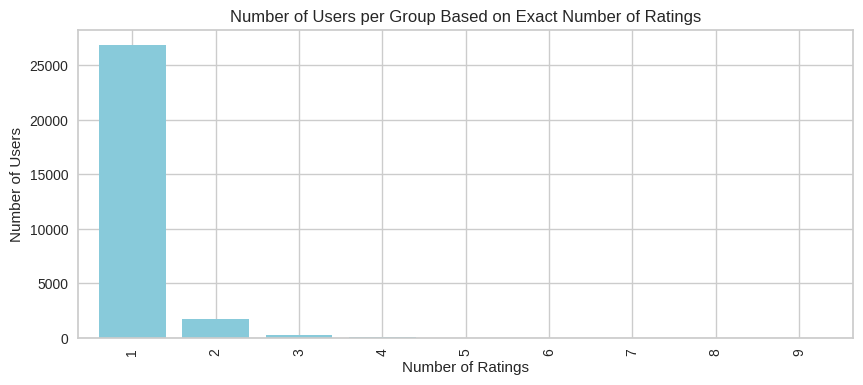

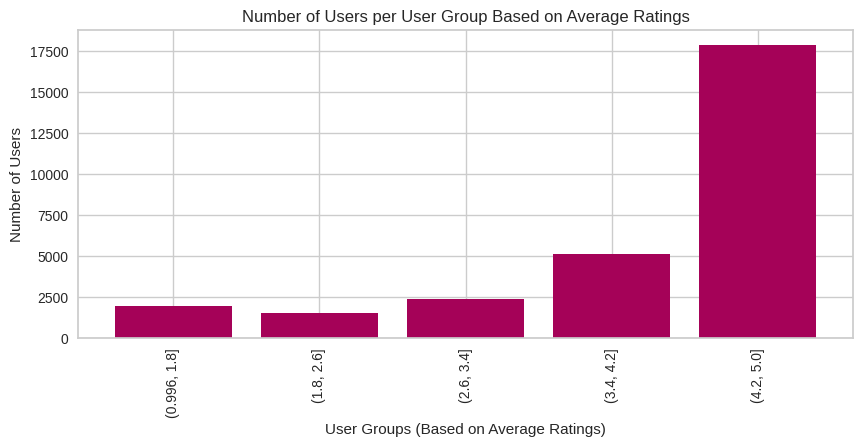

Number of users per user group:
 (0.996, 1.8]     1938
(1.8, 2.6]       1527
(2.6, 3.4]       2406
(3.4, 4.2]       5145
(4.2, 5.0]      17881
Name: rating, dtype: int64
Number of unique items:  1749


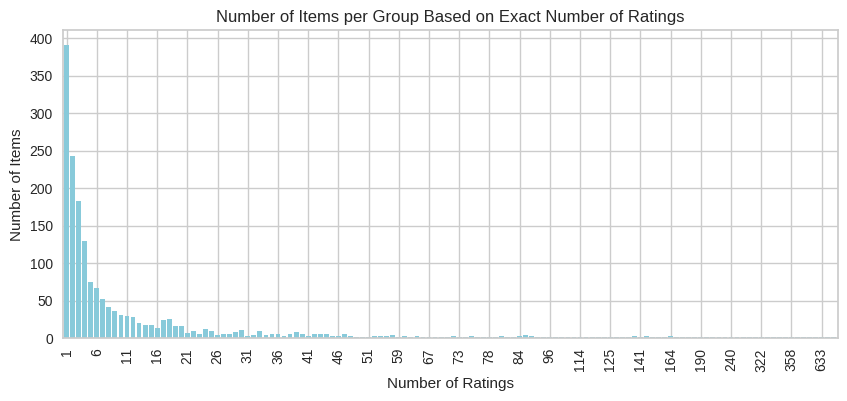

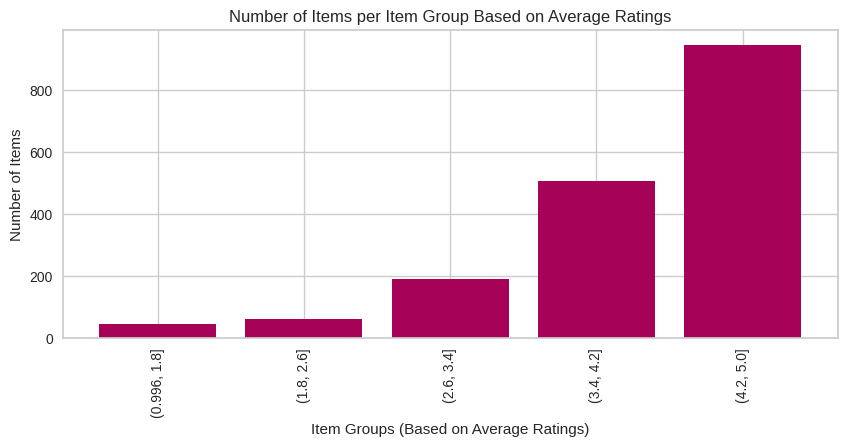

Number of items per item group:
 (0.996, 1.8]     45
(1.8, 2.6]       60
(2.6, 3.4]      191
(3.4, 4.2]      506
(4.2, 5.0]      947
Name: rating, dtype: int64


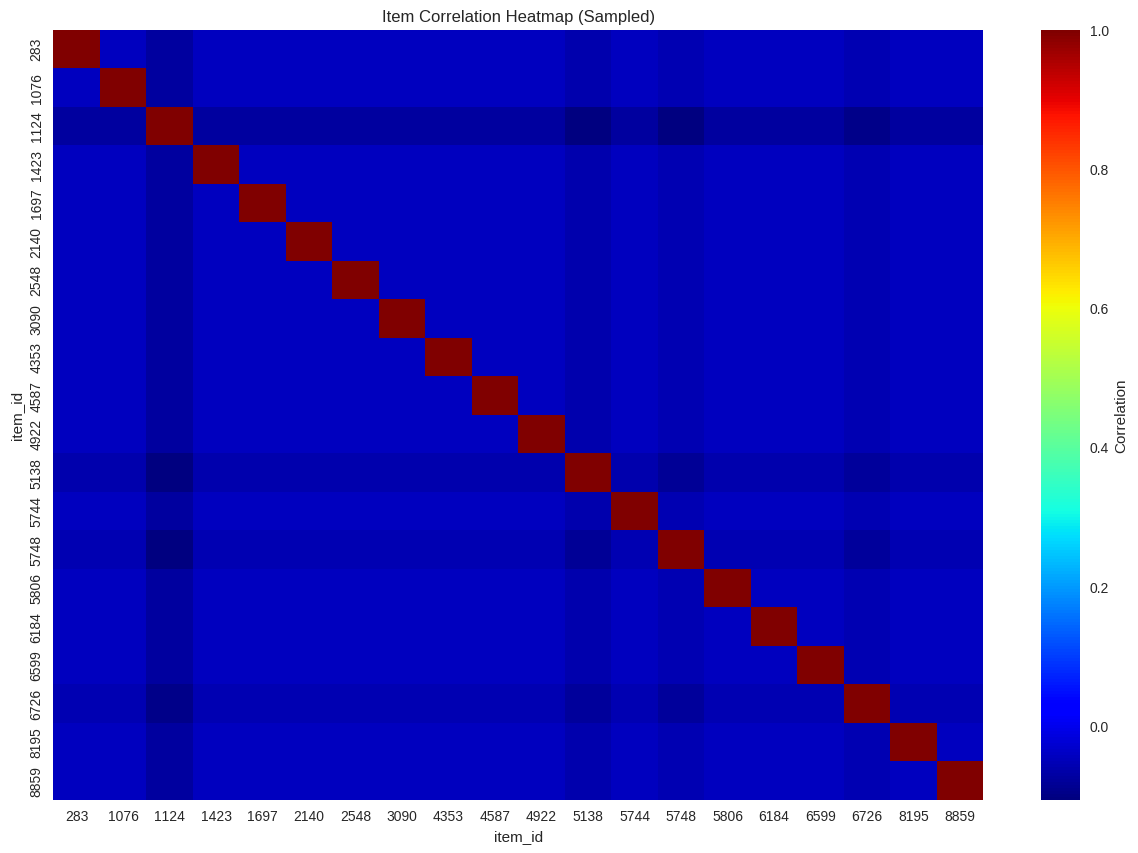

In [118]:
print("Starting visualization...")
clean_copy = clean.copy()

visualizedata.print_visuals(df=clean, user_id=user_id, item_id=item_id,
                            target_attribute=target_attribute,
                            random_state=random_seed, num_users=200,
                            num_items=200)

In [119]:
# filter out users who rated less than 3 times
filtered_df0 = myutils.filter_data(clean_copy, 'user_id',min_val=3)
filtered_df0
# filter out items which were rated less than 2 times
filtered_df1 = myutils.filter_data(filtered_df0, 'item_id',min_val=2)
filtered_df1

(381, 9)
Filtered dataframe shape:  (381, 9)
(111, 9)
Filtered dataframe shape:  (111, 9)


,item_id,user_id,model_attr,category,brand,year,user_attr,split,rating
164939,3029,4378,Female&Male,Headphones,Bose,2013,Male,0,5.0
99408,1670,46878,Female&Male,Headphones,Bose,2011,Female,0,5.0
388906,5748,30677,Female&Male,Portable Audio & Video,Mpow,2015,Female,0,5.0
161615,3029,13746,Female&Male,Headphones,Bose,2013,Male,0,5.0
514176,1882,270692,Female&Male,Headphones,JLAB,2011,Male,0,3.0
...,...,...,...,...,...,...,...,...,...
1005092,7022,270692,Male,Portable Audio & Video,Bose,2015,Male,2,3.0
27624,679,1670,Female,Computers & Accessories,Linksys,2008,Female,0,5.0
185090,1670,174769,Female&Male,Headphones,Bose,2011,Male,0,3.0
437601,5041,4483,Male,Headphones,Bose,2014,Male,0,4.0


Number of unique users:  60


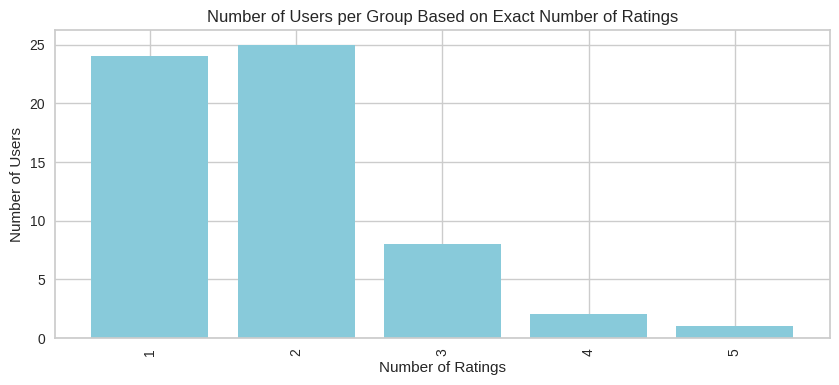

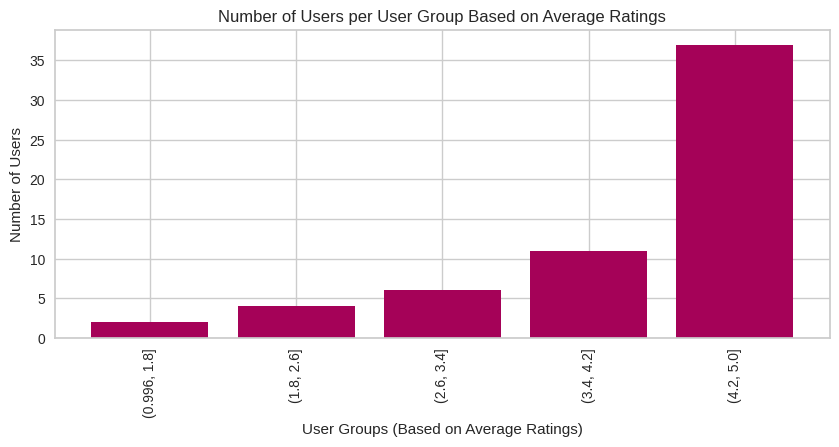

Number of users per user group:
 (0.996, 1.8]     2
(1.8, 2.6]       4
(2.6, 3.4]       6
(3.4, 4.2]      11
(4.2, 5.0]      37
Name: rating, dtype: int64
Number of unique items:  29


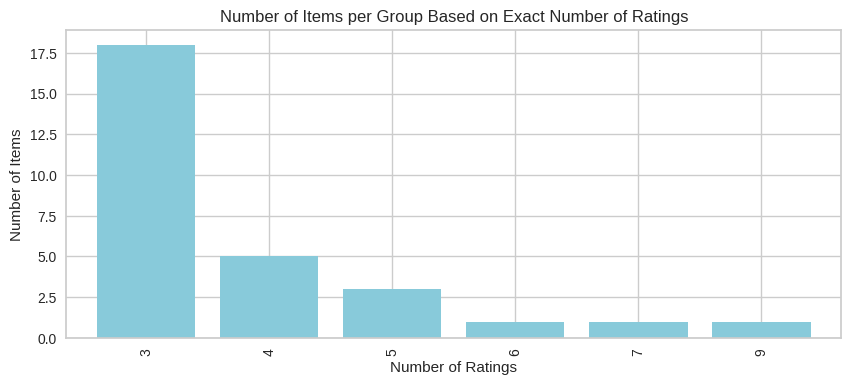

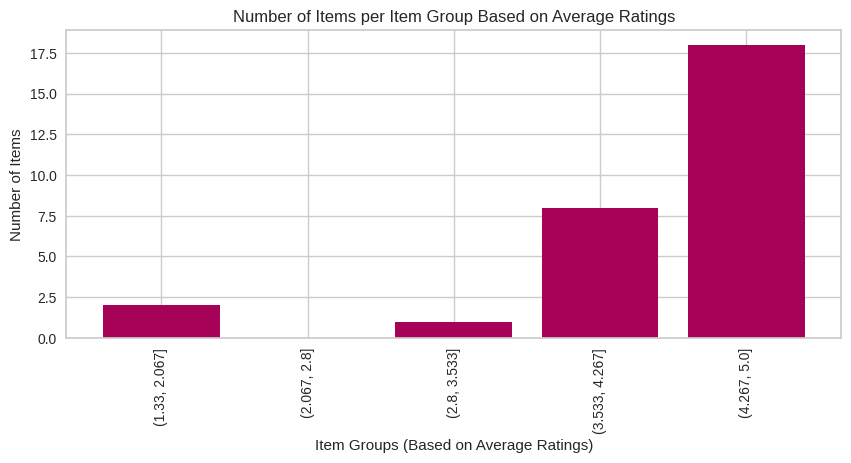

Number of items per item group:
 (1.33, 2.067]      2
(2.067, 2.8]       0
(2.8, 3.533]       1
(3.533, 4.267]     8
(4.267, 5.0]      18
Name: rating, dtype: int64


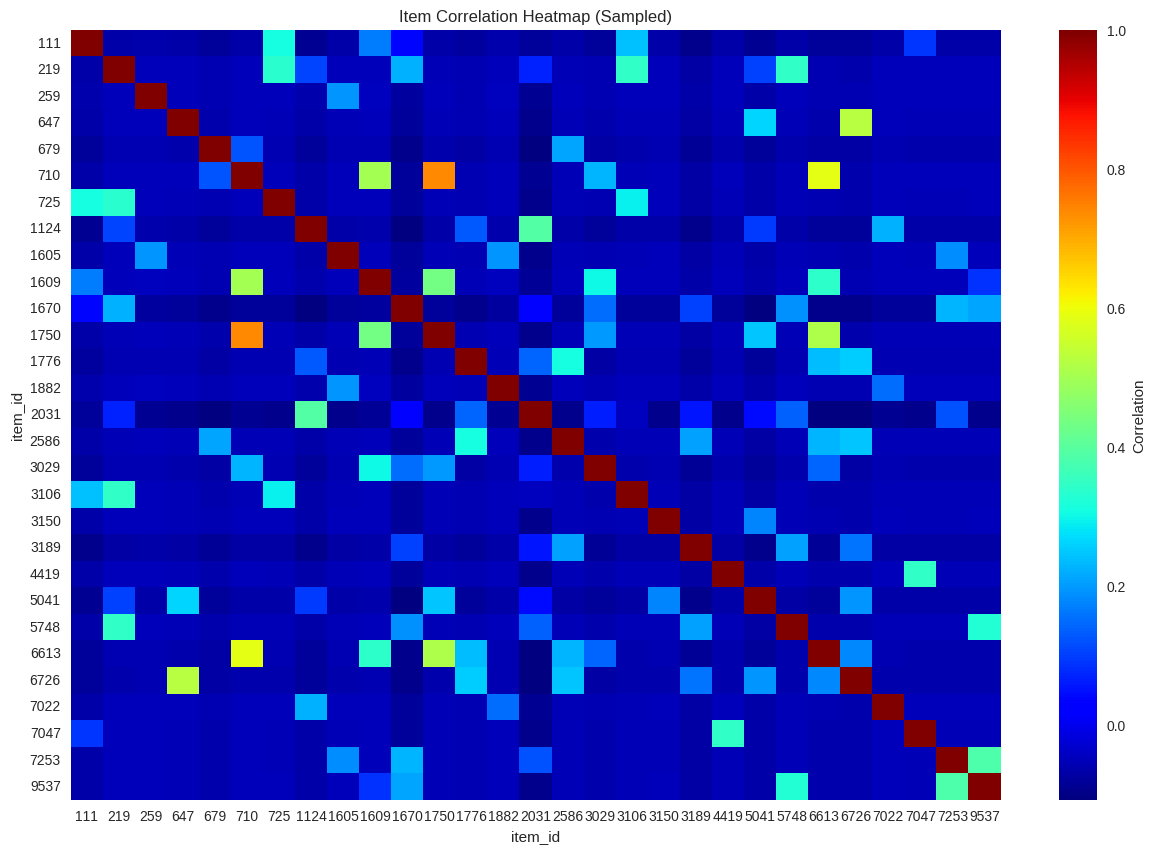

In [120]:
# Re-do visualization
print_visuals(df=filtered_df1, user_id=user_id, item_id=item_id,
                            target_attribute=target_attribute,
                            random_state=random_seed, num_users=60, num_items=29)

In [121]:
# update new x_train and y_train to use filtered training data
x_train_filtered = filtered_df1
x_train_filtered = x_train_filtered.drop(target_attribute, axis=1)
y_train_filtered = filtered_df1[target_attribute]

# TASK 2


### Phase III: Grid Search for Param Tuning

In [132]:
from surprise import Dataset, Reader
from surprise import KNNBaseline, KNNBasic
from surprise.model_selection import KFold

reader = Reader(rating_scale=(0.0, 5.0))
data = Dataset.load_from_df(filtered_df1[['user_id', 'item_id', 'rating']], reader)

# param grids for grid search
param_grids = [
    {'bsl_options': {'method': ['als', 'sgd']}, 'k': [5, 10, 15]},  # KNNBaseline
    {'k': [3, 5, 7], 'sim_options': {'name': ['cosine', 'msd', 'pearson']}},  # KNNBasic
]

models = [KNNBaseline, KNNBasic]

# for printing models with its params
model_grid_pairs = list(zip(models, param_grids))

results = []

# splitting for KFold cross-validation
kf = KFold(n_splits=5, random_state=42)

best_params_list = prepdata.cross_val(data, model_class, param_grid, model_grid_pairs, kf)



KNNBaseline
Best RMSE Score: 1.0521
Best MAE Score: 0.8198
Best Parameters: {'rmse': {'bsl_options': {'method': 'sgd'}, 'k': 5}, 'mae': {'bsl_options': {'method': 'sgd'}, 'k': 5}}


KNNBasic
Best RMSE Score: 1.0922
Best MAE Score: 0.8451
Best Parameters: {'rmse': {'k': 3, 'sim_options': {'name': 'pearson', 'user_based': True}}, 'mae': {'k': 3, 'sim_options': {'name': 'cosine', 'user_based': True}}}



### Phase IV: MODELING

In [144]:
testing = x_test
testing[target_attribute] = y_test

# Convert DataFrame to Surprise Dataset
reader = Reader(rating_scale=(0.0, 5.0))
surprise_train = Dataset.load_from_df(filtered_df1[['user_id', 'item_id', 'rating']], reader)
surprise_test = Dataset.load_from_df(testing[['user_id', 'item_id', 'rating']], reader)

modeldata.model_recs(surprise_train, surprise_test, best_params_list, model_grid_pairs)

AttributeError: ignored